### Jonas Röst, Kailash De Jesus Hornig

In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

# Task 1

## Step 1

In [2]:
#Read data
data_train = pd.read_csv("adult_train.csv")
data_test = pd.read_csv("adult_test.csv")

#Extract features
Ytrain = data_train['target']
Ytest = data_test['target']

Xtrain = data_train.drop(columns=['target'])
Xtest = data_test.drop(columns=['target'])

## Step 2

In [6]:
#Create dictionaries of input data
Xtrain_dict = Xtrain.to_dict('records')
Xtest_dict = Xtest.to_dict('records')

#Create encoded data
dv = DictVectorizer()
X_train_encoded = dv.fit_transform(Xtrain_dict)
X_test_encoded = dv.transform(Xtest_dict)


In [7]:
#Trying out a classifier on the data
dtc = DecisionTreeClassifier(criterion = "gini", splitter="best", min_samples_split = 60)
print("DecisionTreeClassifier cross validation score: "+str(np.mean(cross_val_score(dtc, X_train_encoded, Ytrain))))

#Compute accuracy on test set
dtc.fit(X_train_encoded, Ytrain)
Yguess = dtc.predict(X_test_encoded)
print("Accuracy score: " +str(accuracy_score(Ytest, Yguess)))


DecisionTreeClassifier cross validation score: 0.8522774239840109
Accuracy score: 0.8516061666973773


## Step 3

In [8]:
# automating the same steps but with a pipeline
pipeline = make_pipeline(
  DecisionTreeClassifier()
)

pipeline.fit(X_train_encoded, Ytrain)
print("Accuracy score: " +str(pipeline.score(X_test_encoded, Ytest)))

Accuracy score: 0.8194828327498311


# Task 2

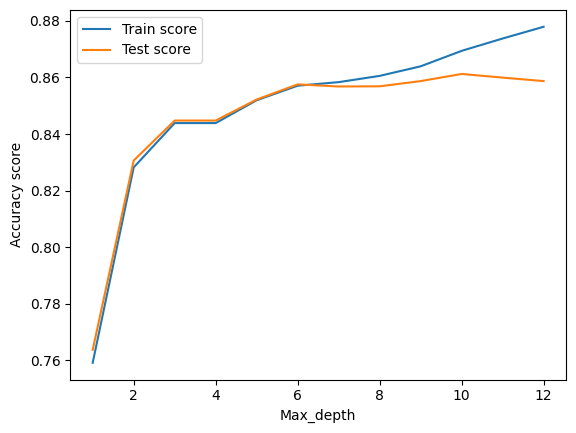

In [9]:
# Underfitting and overfitting in decision tree classifiers

depths = list(range(1,16))
train_score = []
test_score = []

# Calculate scores for each max_depth
for d in depths:
    model = DecisionTreeClassifier(max_depth = d)
    model.fit(X_train_encoded, Ytrain)
    train_score.append(accuracy_score(Ytrain, model.predict(X_train_encoded)))
    test_score.append(accuracy_score(Ytest, model.predict(X_test_encoded)))

#Plot the scores
plt.plot(depths, train_score, label = "Train score")
plt.plot(depths, test_score, label = "Test score")
plt.xlabel("Max_depth")
plt.ylabel("Accuracy score")
plt.legend()

We see the same effect as in the last assignment, where the score on the train data set keeps increasing as the max_depth increases. At the same time the score on the test set stops increasing after max_depth = 6. However, the test score does not get worse like in the last assignment, instead it plateaus and is close to constant for max_depth > 6.  

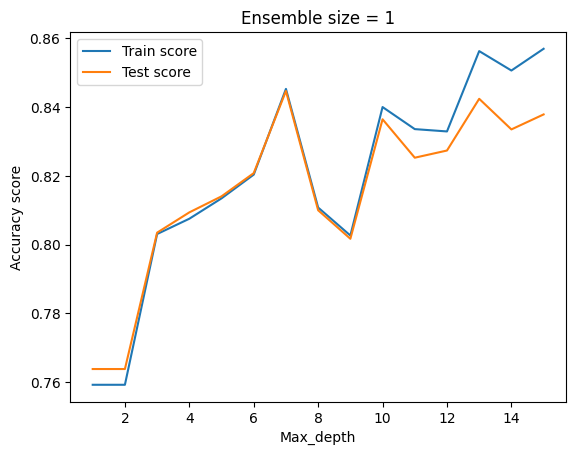

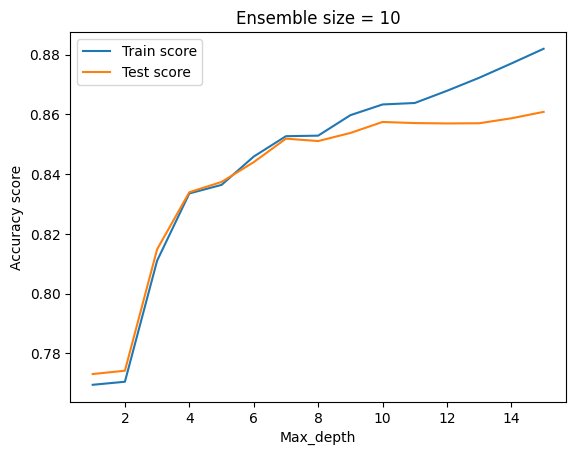

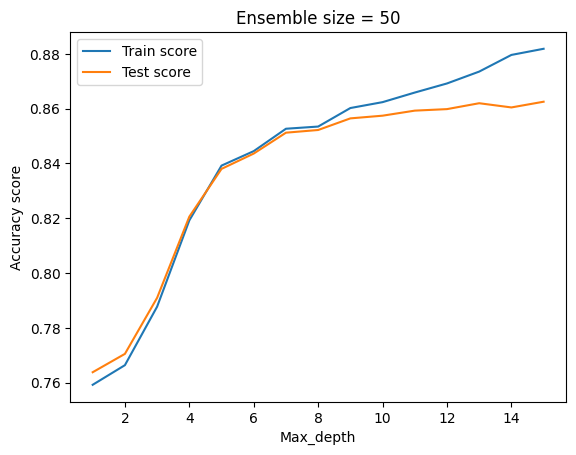

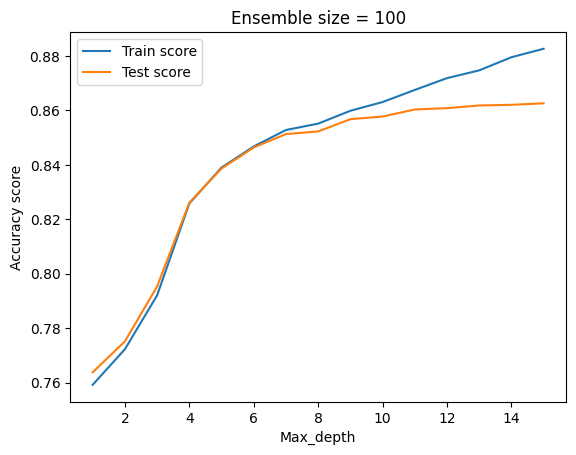

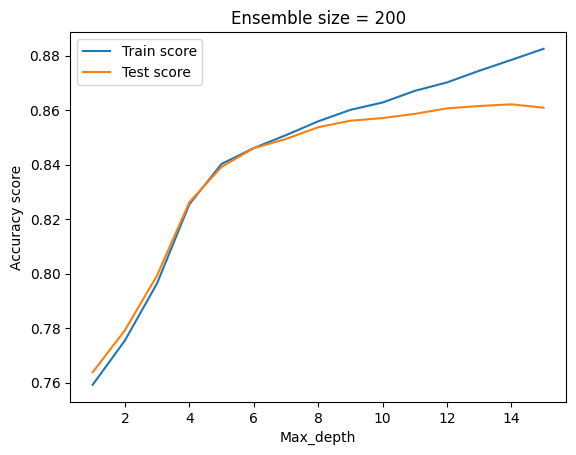

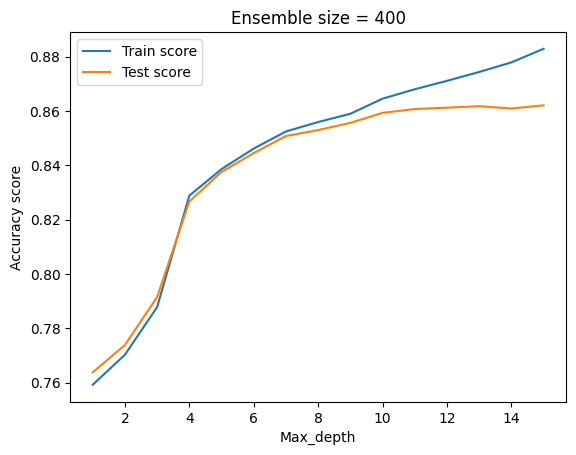

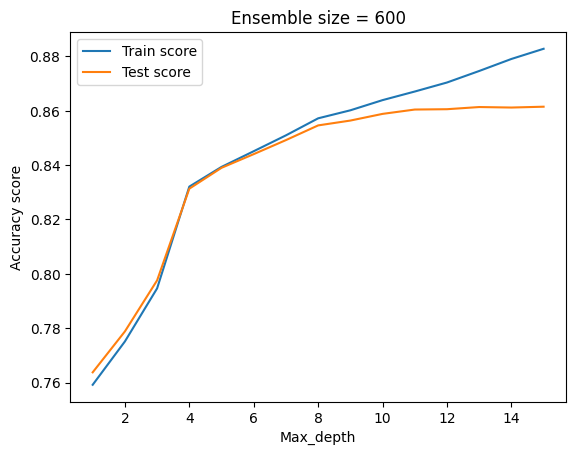

In [11]:
# Underfitting and overfitting in random forest classifiers

number_of_trees = [1, 10, 50, 100, 200, 400, 600]
depths = list(range(1,16))


for trees in number_of_trees:
    train_score = []
    test_score = []
    
    # Calculate scores for each max_depth
    for d in depths:
        model = RandomForestClassifier(n_estimators = trees, max_depth = d, n_jobs = 3)
        model.fit(X_train_encoded, Ytrain)
        train_score.append(accuracy_score(Ytrain, model.predict(X_train_encoded)))
        test_score.append(accuracy_score(Ytest, model.predict(X_test_encoded)))

    #Plot the score for current ensamble
    plt.plot(depths, train_score, label = "Train score")
    plt.plot(depths, test_score, label = "Test score")
    plt.xlabel("Max_depth")
    plt.ylabel("Accuracy score")
    plt.title("Ensemble size = "+str(trees))
    plt.legend()
    plt.show()

**What's the difference between the curve for a decision tree and for a random forest with an ensemble size of 1, and why do we see this difference?**

The difference is that the train score curve increases later for the random forest, than it does for the decision tree classifier. In the first graph the two curves split after a depth of 6, while it takes a depth of around 10 for the random forest graph. The reason for this difference might be because of the randomization at each node split. In the decision tree we choose to split on the best feature each time. In the random forest we consider a subset of all the features when deciding the best split which means that the single tree created with every new iteration of different depths will look different from the decision tree grapth above. Moreover, looking at the smaller values of max_depths for the two cases it can be observed that the test score for the ensemble model is slighlty higher than the training score, while they are more equal in the tree case.

**What happens with the curve for random forests as the ensemble size grows?**

As the ensemble size grows, the more similar the test score curve and the training score curve becomes. At a certain point they intersect, and then diverge as the training curve increase towards 100% and the test cruve flattens(increases slowly) around a certain value.  Using a ensemble size of 10 shows that we reduce the overfitting that can be seen in the decision tree case somewwhat. Later on, there is not that big of a difference between the plots for ensemble sizes > 10. The difference in training and test accuracy grows for all these ensemble sizes as max_depth increases after max_depth = 6. However, this is not because the test accuracy decreases, like in the decision tree case.

**What happens with the best observed test set accuracy as the ensemble size grows?**

For all random forests with ensemble size > 10, the best observed test set accuracy is attained when max_depth = 16, i.e. the last value. However, the best accuracy seems to be approximatly the same for all these random forests indicating that the accuracy might be less sensitive to changes in ensemble size when the max_depth is large. 

**What happens with the training time as the ensemble size grows?**
As the ensemble grows the training time increases which is notable when running the code. This is understandable as we train more and more trees each time. Say that the time it takes to train one tree is *t*. Hence, increasing the ensemble size with 100 trees, increases the total time with 100 * t. With parallel training the increase in time might not behave exactly like this but the increase in amount of trees does still affect the training time. 

# Task 3

In [12]:
# Implements a random forest classifier to assess importance score of the features 

# Base the hyperparemeters on the task 2, good accuracy with resonable computational time
rf = RandomForestClassifier(n_estimators = 100, max_depth = 12, n_jobs = 3)
rf.fit(X_train_encoded, Ytrain)
print(accuracy_score(Ytest, rf.predict(X_test_encoded)))

0.8608193599901726


In [31]:
# merging feature namens and feature importance scores
feature_importance = pd.DataFrame(list(zip(dv.feature_names_, rf.feature_importances_)), columns = ['Feature name', 'Importance'])
feature_importance.sort_values(by = 'Importance', ascending = False).head(10)

,Feature name,Importance
23,marital-status=Married-civ-spouse,0.170816
1,capital-gain,0.155907
3,education-num,0.092627
90,relationship=Husband,0.088622
0,age,0.065108
20,hours-per-week,0.045771
2,capital-loss,0.039242
25,marital-status=Never-married,0.034402
74,occupation=Exec-managerial,0.031487
80,occupation=Prof-specialty,0.024850


**Reason about why we got this result of importance**

Three of the top ten most important features revolve around the relationship status of the person. The relationship status of a person can plausibly have an effect on how much that person is able, or wants, to work which in turn might affect the salary. (higher proportion of married individuals in the later stages of life?) That the amount of hours an individual works has an impact on the salary is also shown by the feature *hours-per-week* being in the top 10. 

Another feature that is in the top ten is *occupation=Exec-managerial* which means that a person has a higher placed position in the organization. Usually these positions also come with a higher salary, thus making it an important feature when predicting whether a person has a high salary or not. Furthermore, there are two features regarding education. It should be reasonable to assume that you have an higher salary after completing higher levels of education and a lower salary if you only have a high-school degree, for example. 

Lastly, *age* is also quite intuitive as salary levels increase over the time of a career with advancing roles and advancing levels of expertise that one can be paid for. Older people tend to have more senior positions that usually pay more than more junior roles, mostly occupied by younger people. We also think that it is reasonable that captital gain and loss is a feature that is good for discriminating between the two lables as capital movement should be affected by salary levels. The more money you earn the more you e.g. invest and the more capital gains you can make (Note: we are a bit unsure about the exact definition of these two measures).

**Alternative way to compute importance score**

One alternative way to compute the feature importance score is by using *permutation importance*. The idea is to examine one feature at a time and compare how perturbations to the values of this feature/column affects the accuracy score, compared to a baseline.

We start by computing the baseline accuracy for the random forest above on our test data. Then we iterate over all of our features in the test data. We do the perturbation by permutating the values in the current column. Then we again calculate the accuracy score of the random forest using this "new" test data. The importance for the current feature is calculated by taking the difference between the baseline accuracy and the "new" accuracy. Lastly, we replace the perturbed column with the original column to obtain the original test data set.

Another alternative that should work, although not being a very good way to determine the importance of a feature, is to start by spliting on the two different classes to predict (<=50k, >50k), then count the frequency of each feature found in each splitt of the classes. If we can find features with significantly different numbers of counts, ie. high for one and low for the other or vice versa, then that should indicate that given feature is pretty good for discriminating between the classes. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fb10e4e7-3851-48d2-9a1d-280535dc70fe' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>